In [8]:
import pandas as pd
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import earthpy.plot as epp
import earthpy as ep
from glob import glob

### GDAL Exploration

In [15]:
#Open File
file_names = ['enteric','manure','total']
file_path = 'data/{0}_CH4_Gg_km2.tif'.format(file_names[1])

dataset = gdal.Open(file_path, gdal.GA_ReadOnly) 

In [29]:
!gdalinfo {file_path}

Driver: GTiff/GeoTIFF
Files: data/manure_CH4_Gg_km2.tif
Size is 90, 92
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-124.290461078000007,41.926291697499998)
Pixel Size = (0.100000000000000,-0.100000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-124.2904611,  41.9262917) (124d17'25.66"W, 41d55'34.65"N)
Lower Left  (-124.2904611,  32.7262917) (124d17'25.66"W, 32d43'34.65"N)
Upper Right (-115.2904611,  41.9262917) (115d17'25.66"W, 41d55'34.65"N)
Lower Right (-115.2904611,  32.7262917) (115d17'25.66"W, 32d43'34.65"N)
Center      (-119.7904611,  37.3262917) (119d47'25.66"W, 37d19'34.65"N)
Band 1 Block=128x128 Type=Float32, ColorInterp=Gray
  NoData Value=-9999
  Metadata:
    Re

In [16]:
# (x-coordinate of top left corner, 
# horizontal pixel resolution west-> east,
# unknown,
# y-coordinate of top left corner,
# unknown,
# vertical pixel resolution north-> south,
# )
gt = dataset.GetGeoTransform()
gt

(-124.290461078, 0.1, 0.0, 41.9262916975, 0.0, -0.10000000000000003)

In [17]:
proj = dataset.GetProjection()
proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [18]:
# Check number of Raster bands, each band essentially is a data point per the actual geo point
dataset.RasterCount

1

In [19]:
#Access individual pixel values, indicate the methane emissions in theory...? 
# Note GetRasterBand() takes band no. starting from 1 not 0
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()

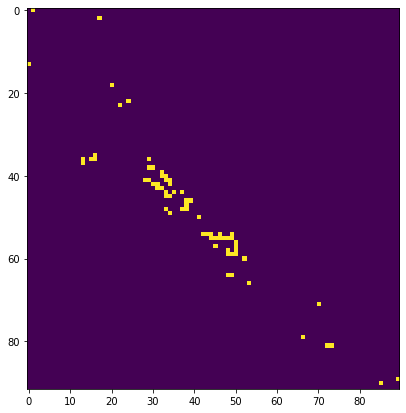

In [20]:
#Plot Image
plt.figure(figsize=(7, 7))
plt.imshow(arr)

In [21]:
#Mask for any point that has an actual reading
# here generally i would do 1,0 ... just for fun flipping it
mask = np.where((arr != -9.9990000e+03), 0, 1)

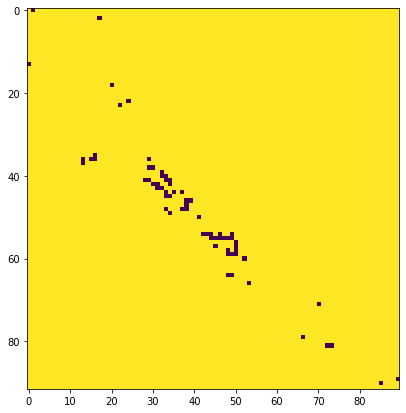

In [22]:
# flipped mask
plt.figure(figsize=(7, 7))
plt.imshow(mask)

In [23]:
#Exporting our modified geoTiff file 
# Need a GeoTiff Raster driver - driver is essentially the vessel that will take our dataset
# in and write it out to a file


driver = gdal.GetDriverByName("GTiff")
driver.Register()

outds = driver.Create("data/sample_mask.tif", 
                      xsize= mask.shape[1],
                      ysize= mask.shape[0],
                      bands = 1,
                      eType = gdal.GDT_Int16
                     )

#Need to set these meta data fields, in our case just reusing what we had already,
outds.SetGeoTransform(gt)
outds.SetProjection(proj)


#Need to open raster band, and write our new data (in this case `mask`) to this raster band
outband = outds.GetRasterBand(1)
outband.WriteArray(mask)
outband.SetNoDataValue(np.nan)

#Actually write to the disk
outband.FlushCache()

#Need to do this get rid of shit from the driver to the actual rastered file
outband = None
outds = None


In [24]:
#Check that the file is written there!

!ls data

enteric_CH4_Gg_km2.tif sample_mask.tif
manure_CH4_Gg_km2.tif  total_CH4_Gg_km2.tif


<hr>

### Blog Code

* https://medium.com/@manishsahu/working-with-geospatial-data-part-1-using-gdal-library-38bdc26ff958
* clipping stuff: https://medium.com/@manishsahu/working-with-geospatial-data-part-3-basic-data-processing-53a2a3a91c68

In [25]:
# Reading raster dataset
def read_tif(path_tif):

    # Creating gdal object
    ds = gdal.Open(path_tif)
    
    # Reading number of bands
    num_band = ds.RasterCount
    
    # Reading rows and cols
    col = ds.RasterXSize
    row = ds.RasterYSize
    
    # Initializing array
    array = np.zeros([row, col, num_band])
    for i in range(num_band):
        band = ds.GetRasterBand(i+1)
        arr = band.ReadAsArray()
        array[:, :, i] = arr
    size = arr.shape
    
    # Reading geotransformation and geoprojection
    geotransform = ds.GetGeoTransform()
    geoprojection = ds.GetProjection()
    return geotransform, geoprojection, (size[1], size[0]), array


 #### #### #### #### #### #### #### #### #### #### #### #### #### #### 


# Writing raster dataset
def write_tif(path_tif, array, geotransform, geoprojection):
    
    # Checking the dimension of array.
    dim_array = array.shape
    if len(dim_array) > 2:
        depth = dim_array[2]
    else:
        depth = 1
    
    # Initializing TIF dataset driver
    driver = gdal.GetDriverByName("GTiff")
    
    # Creating actual dataset from TIF drivers.
    outdata = driver.Create(
        path_tif, size[0], size[1], depth, gdal.GDT_Float32)
    

    # sets same geotransform as input
    outdata.SetGeoTransform(geotransform)
    
    # sets same projection as input
    outdata.SetProjection(geoprojection)  
    
    # Writing data to array
    for i in range(depth):
        try:
            arr = array[:, :, i]
        except:
            arr = array[:, :]
        outdata.GetRasterBand(i+1).WriteArray(arr)
    
    # If you want these values transparent
    outdata.GetRasterBand(1).SetNoDataValue(-9999) 
    
    # saves to disk!!
    outdata.FlushCache() 
    
    # Releasing memory
    outdata = None

In [26]:
geotransform, geoprojection, data_shape, data = read_tif(file_path)

In [27]:
print('geotransform', geotransform, '\n')
print('geoprojection', geoprojection, '\n')
print('data_shape', some_tuple, '\n')

geotransform (-124.290461078, 0.1, 0.0, 41.9262916975, 0.0, -0.10000000000000003) 

geoprojection GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]] 



NameError: name 'some_tuple' is not defined